In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.discrete.count_model import ZeroInflatedPoisson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib

DATA_PATH = pathlib.Path().cwd() / "data"

# Poisson Regression

## Basic Definitions

- **y**: Number of events observed  
- **t**: Time or exposure  
- **λ = y / t**: Event rate  

Poisson probability distribution:

$$
P(Y = y) = \frac{e^{-λt} (λt)^y}{y!}
$$

## Model Formulation

- **Expected Value**:  
  $$
  \mathbb{E}[Y] = λt
  $$

- **Variance**:  
  $$
  \text{Var}(Y) = λt
  $$

- **Model Equation**:
  $$
  λ = e^{β_0 + β_1 x_1 + ... + β_k x_k}
  $$
  $$
  \log(λ) = β_0 + β_1 x_1 + ... + β_k x_k
  $$

Log transformation ensures positivity and enables linear modeling.


## Model Assumptions

1. Mean equals variance:  
   $$
   \mathbb{E}[Y] = \text{Var}(Y)
   $$
2. Observations are independent  
3. Errors follow a Poisson distribution  


## Overdispersion Diagnosis

To test if **mean = variance** assumption holds:

**Overdispersion factor:**

$$
\text{OD} = \frac{\sum_i \left( \frac{y_i - \hat{y}_i}{\sqrt{\hat{y}_i}} \right)^2}{n - p} = \frac{\chi^2_{\text{Pearson}}}{\text{df}_{\text{resid}}}
$$

### Interpretation:

| Value of OD  | Meaning                          |
|--------------|----------------------------------|
| ≈ 1.0        | No overdispersion (ideal)        |
| > 1.5        | Overdispersion → use Neg. Binomial |
| < 1.0        | Underdispersion (rare)           |

Poisson regression does **not** have a true R², but several Pseudo R² metrics exist (e.g., McFadden's, Cragg-Uhler, Cox-Snell).

Typical interpretation:

| Pseudo R² Range | Interpretation           |
|------------------|--------------------------|
| < 0.1            | Weak fit (common in count models) |
| 0.1 – 0.2        | Moderate explanatory power |
| 0.2 – 0.4        | Good fit for Poisson data |
| > 0.4            | Rare, indicates very strong relationship or overfitting |




## Summary

- Use **count model** if time/exposure is constant  
- Use **rate model** if exposure varies, with `log(t)` as offset  
- Always check for **overdispersion**

# Poisson Regression For Count Data

If every observation covers the same time window, the model equation would be:

$$
\log(\mathbb{E}[Y]) = β_0 + β_1 x_1 + ... + β_k x_k
$$



For this particular problem:

$$
\text{satıs\_sayısı} = e^{b_0 + b_1\times\text{musteri\_sayisi} + b_2\times{promosyon}}
$$

Timeframe of each instance is daily so model the count data directly.

In [2]:
data = pd.read_csv(DATA_PATH / "SalesData.csv",index_col=0)
data.head(3)

,promosyon,musteri_sayisi,satis_adedi
gun,,,
1,0,51,1
2,1,67,2
3,1,53,2


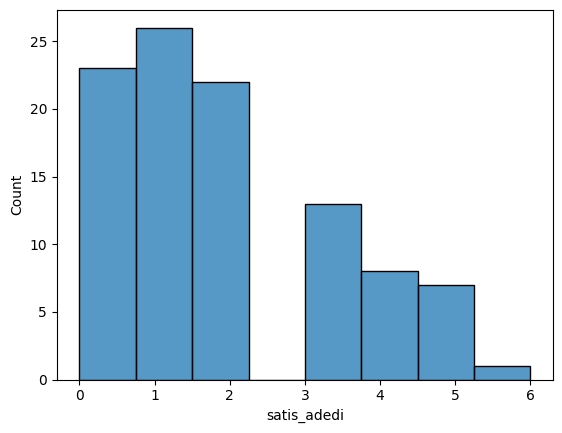

In [3]:
plt.plot()
sns.histplot(data["satis_adedi"])
plt.show()

In [4]:
formula = "satis_adedi ~ promosyon + musteri_sayisi"
model = smf.glm(formula,data,family=sm.families.Poisson())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            satis_adedi   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -164.13
Date:                Tue, 08 Jul 2025   Deviance:                       125.72
Time:                        10:09:05   Pearson chi2:                     109.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2280
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.2836      0.573     -2.

Pseudo $R^2$ = 0.22 $→$ Good Fit

$\frac{Pearson χ}{dof} = \frac {109} {97} ≈ 1$ $→$ No Overdispersion

#Poisson Regression for the Rate Data

If time or exposure varies across observations, the model equation would be:

$$
\log(\mathbb{E}[Y]) = β_0 + β_1 x_1 + ... + β_k x_k + \log(t)
$$

Where `log(t)` is an **offset** (added, not estimated).

$$
log(\text{donusum\_sayısı}) = b_0 + b_1\times\text{kampanya} + log(\text{ziyaret\_sayısı})
$$

In [5]:
df = pd.read_csv(DATA_PATH / "PoissonRateData.csv",index_col=0)
df.head(3)

,kampanya,ziyaret_sayisi,donusum_sayisi
gun,,,
1,1,301,1
2,0,274,1
3,0,291,4


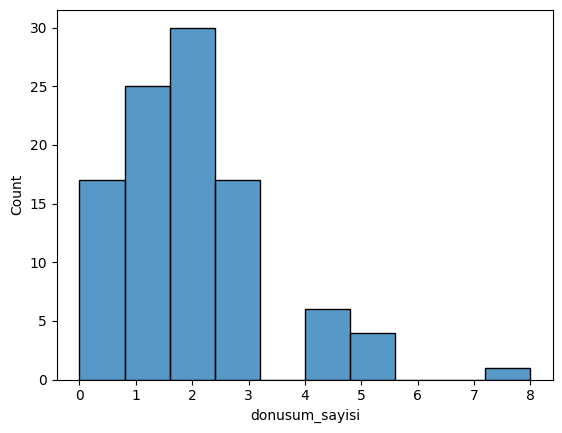

In [6]:
plt.figure()
sns.histplot(df["donusum_sayisi"])
plt.show()

In [7]:
formula = "donusum_sayisi ~ kampanya"
model = smf.glm(
    formula=formula,
    data=df,
    family=sm.families.Poisson(),
    offset=np.log(df["ziyaret_sayisi"])
)
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         donusum_sayisi   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -166.39
Date:                Tue, 08 Jul 2025   Deviance:                       116.05
Time:                        10:09:05   Pearson chi2:                     104.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.05872
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.2270      0.100    -52.270      0.0

# Zero-Inflated Poisson Regression (ZIP)

**Zero-Inflated Poisson (ZIP)** regression is used when the dataset contains more zero observations than expected under a standard Poisson model — **but there is no significant overdispersion** (i.e., mean ≈ variance for non-zero counts). It is a two-component mixture model.

## 1. Logistic Model (Inflation Part)
A logistic regression is used to model the probability that an observation is from the **"always-zero" group** (structural zeros).  
This component separates:

- **Structural zeros**: Observations that are always zero due to some underlying condition  
- **Non-structural zeros**: Observations that could have been positive, but happened to be zero

Formally:
$$
P(Y_i = 0) = \pi_i + (1 - \pi_i) \cdot e^{-\lambda_i}
$$
where  $\pi_i$  is the probability of being an always-zero case.



## 2. Poisson Model (Count Part)
The standard Poisson regression is fitted to model the **count process** for the remaining observations (including both non-zero values and Poisson-generated zeros).

Formally:
$$
\log(\lambda_i) = \beta_0 + \beta_1 x_{i1} + \dots + \beta_k x_{ik}
$$

## Interpreting Pseudo R² in ZIP Models

While Pseudo R² in Zero-Inflated Poisson (ZIP) models is not directly comparable to R² in linear regression, it still provides a useful heuristic for model fit.

| Pseudo R² Range  | Interpretation (for ZIP models)                                   |
|------------------|--------------------------------------------------------------------|
| < 0.05           | Weak fit — predictors explain very little variation               |
| 0.05 – 0.15      | Typical and acceptable — especially in zero-heavy count data       |
| > 0.20           | Strong model — relatively rare, shows substantial explanatory power|
| > 0.40           | Suspiciously high — may indicate overfitting or data leakage       |

If LLR p-value < 0.05, then it means that the model is meaningful.


## Use Cases

Use ZIP when:

- The data has **excess zeros**
- But the variance is **not significantly greater than** the mean (i.e., no overdispersion)
- There is reason to believe that some zeros are **structural**

If both **excess zeros** and **overdispersion** are present, consider using a **Zero-Inflated Negative Binomial (ZINB)** model instead.

Don't use ZIP if 0's are not structured!



In [8]:
zip_data = pd.read_csv(DATA_PATH / "ZIPData.csv")
zip_data.head(3)

,kampanya,donusum_sayisi,kullanici_turu
0,1,0,1
1,0,1,0
2,0,1,1


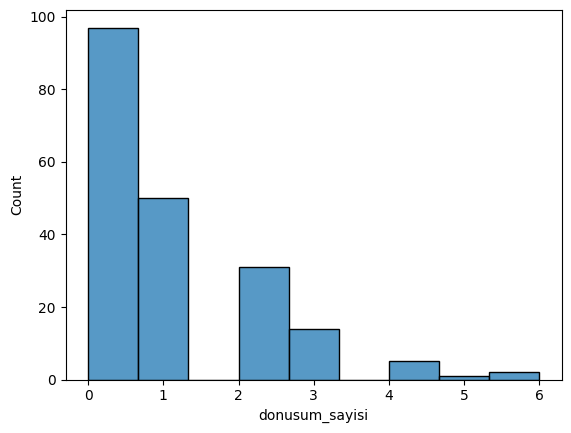

In [9]:
plt.figure()
sns.histplot(zip_data["donusum_sayisi"])
plt.show()

In [10]:
X = sm.add_constant(zip_data[["kampanya", "kullanici_turu"]])
y = zip_data["donusum_sayisi"]

zip_model = ZeroInflatedPoisson(endog=y, exog=X, exog_infl=X, inflation='logit')
zip_result = zip_model.fit(method='bfgs', maxiter=100, disp=0)

print(zip_result.summary())

                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:          donusum_sayisi   No. Observations:                  200
Model:             ZeroInflatedPoisson   Df Residuals:                      197
Method:                            MLE   Df Model:                            2
Date:                 Tue, 08 Jul 2025   Pseudo R-squ.:                 0.07592
Time:                         10:09:05   Log-Likelihood:                -249.24
converged:                        True   LL-Null:                       -269.72
Covariance Type:             nonrobust   LLR p-value:                 1.281e-09
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
inflate_const             -0.7651      0.475     -1.611      0.107      -1.696       0.166
inflate_kampanya          -1.5589      0.763     -2.043      0.041      -3.055      -0.

# Negative Binomial Poisson Regression

In [11]:
nb_data = pd.read_csv(DATA_PATH / "NegativeBinomialData.csv")
nb_data.head(3)

,kampanya,kullanici_turu,satis_adedi
0,0,0,0
1,1,1,0
2,1,1,0


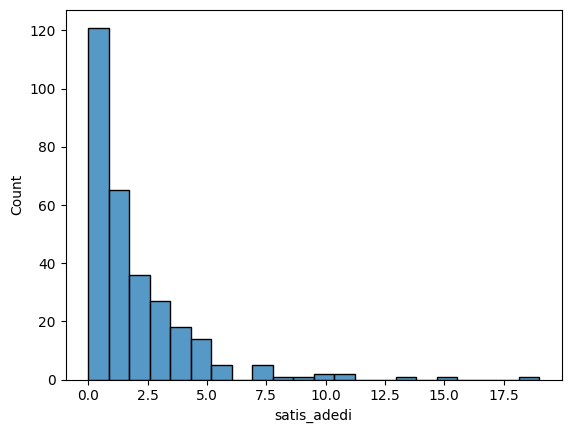

In [12]:
plt.figure()
sns.histplot(nb_data["satis_adedi"])
plt.show()

Sales assumed not to have structural 0's. Therefore a zero inflated model did not employed.

In [13]:
temp_model = smf.glm(
    formula="satis_adedi ~ kampanya + kullanici_turu",
    data=nb_data,
    family=sm.families.Poisson()
).fit()

pearson_chi2 = sum(temp_model.resid_pearson**2)
df_resid = temp_model.df_resid
overdispersion_factor = pearson_chi2 / df_resid

pearson_chi2, df_resid, overdispersion_factor

(966.5851746336996, np.int64(297), np.float64(3.254495537487204))

$3.25 > 1.5$; Overdispersion exists. Therefore Negative Binomial Poisson Regression should be used.

In [14]:
formula = "satis_adedi ~ kullanici_turu + kampanya"
nb_model = smf.glm(formula, data = nb_data, family=sm.families.NegativeBinomial())
nb_result = nb_model.fit()
print(nb_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            satis_adedi   No. Observations:                  300
Model:                            GLM   Df Residuals:                      297
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -533.47
Date:                Tue, 08 Jul 2025   Deviance:                       340.57
Time:                        10:09:05   Pearson chi2:                     351.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.06451
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1105      0.131      0.

c:\Users\Egemen\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


# Variance Inflation Factor (VIF)

VIF is used to detect multicollinearity between the predictor variables in a regression model.  
It tells us how much the **variance** of a regression coefficient is increased because the variable is **correlated with other predictors**.

$$
VIF_{x_1} = \frac{1}{1 - R^2_{x_1}}
$$

Where $R^2_{x_1}$ is the R-squared value from a regression of $x_1$ on all the other predictors:

$$
x_1 = b_0 + b_2x_2 + b_3x_3 + \ldots + b_kx_k
$$


| VIF Range | Interpretation                                  |
|-----------|--------------------------------------------------|
| 1         | No multicollinearity                            |
| 1–5       | Low to moderate multicollinearity (acceptable)  |
| 5–10      | High multicollinearity (potential concern)       |
| > 10      | Very high multicollinearity (serious problem)    |





In [ ]:
np.random.seed(1)
x1 = np.random.normal(50, 10, 100)
x2 = x1 + np.random.normal(0, 5, 100) 
x3 = np.random.normal(30, 5, 100)

df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "x3": x3
})

X = sm.add_constant(df)
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

  feature        VIF
0   const  74.701754
1      x1   5.194730
2      x2   5.205396
3      x3   1.043826


# Confounding

**Confounding** occurs when a predictor variable shares a hidden association with both the outcome variable and another predictor, leading to a distorted estimation of the true relationship.

A **confounding variable** is one that:
- Is associated with the independent variable,
- Influences the dependent variable,
- And is **not included** in the model, which results in **overstated or misleading effects** of the predictor on the outcome.

## How to Detect a Confounding Variable?

1. **Domain Expertise:** Use subject-matter knowledge to identify variables that are logically related to both the predictor and the outcome.

2. **Correlation Analysis:** Look for variables that are correlated with both the independent variable and the dependent variable. High correlations in both directions are strong indicators of potential confounding.


Confounding shouldn't be mixed up with multicollinearity. Confounding happens when an outside variable affects both the predictor and the outcome, making the effect look stronger or weaker than it really is. Multicollinearity means that two or more predictors are too similar, which makes it hard to tell which one really matters. 

How to differentiate multicollinearity from confounding? Use the Variance Inflation Factor (VIF) to detect multicollinearity, or check for very high correlations between predictor variables (typically above 0.8).


In [16]:
confounding_data = pd.read_csv(DATA_PATH / "ConfoundingData.csv")
confounding_data.head()

,kampanya,kullanici_tipi,satis
0,1,1,2
1,0,0,2
2,1,0,2
3,1,1,2
4,0,1,2


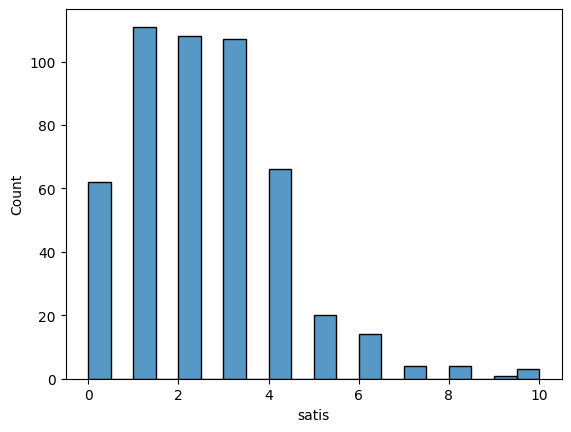

In [17]:
sns.histplot(confounding_data["satis"]);

In [22]:
confounding_data.corr()

,kampanya,kullanici_tipi,satis
kampanya,1.000000,0.512411,0.384706
kullanici_tipi,0.512411,1.000000,0.451553
satis,0.384706,0.451553,1.000000


In [ ]:
X = sm.add_constant(confounding_data[["kampanya", "kullanici_tipi"]])
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,feature,VIF
0,const,2.153636
1,kampanya,1.356051
2,kullanici_tipi,1.356051


The 0.51 correlation between kampanya and kullanici_tipi suggests that kullanici_tipi may confound the effect of kampanya on satis. However, the VIF values indicate that there is no multicollinearity between the predictors.

In [20]:
formula1 = "satis ~ kullanici_tipi"
formula2 = "satis ~ kampanya + kullanici_tipi"
no_confound_model = smf.glm(formula = formula1, data = confounding_data, family=sm.families.Poisson())
confound_model = smf.glm(formula=formula2, data = confounding_data, family=sm.families.Poisson())

print(no_confound_model.fit().summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  satis   No. Observations:                  500
Model:                            GLM   Df Residuals:                      498
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -885.98
Date:                Mon, 07 Jul 2025   Deviance:                       563.69
Time:                        15:56:30   Pearson chi2:                     506.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2340
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.4816      0.049      9.

In [21]:
print(confound_model.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  satis   No. Observations:                  500
Model:                            GLM   Df Residuals:                      497
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -876.03
Date:                Mon, 07 Jul 2025   Deviance:                       543.78
Time:                        15:56:37   Pearson chi2:                     485.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2639
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.4158      0.052      8.